# Deep learning model and correction of bias

Hypothesis: removing variables ZIP, rent, job_stability and occupation reduces bias against minority in model. 

Removing variables rent, ZIP, occupation and job_stability removes bias from model according to demographic parity, equal opportunity and equalised odds measurements.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

/Users/Rolf/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
seed = 123
np.random.seed(seed)

In [60]:
#import pre_processed train dataset
train = pd.read_csv('train_preprocessed.csv', index_col=0)
print('train shape: ' + str(train.shape))
train.head()

train shape: (471136, 13)


,minority,sex,ZIP,rent,education,age,income,loan_size,payment_timing,year,job_stability,occupation,default
0,1,0,1,1,57.230650,36.050927,205168.022244,7600.292199,3.302193,0,3.015554,1,1
1,1,0,1,1,45.891343,59.525251,187530.409981,5534.271289,3.843058,0,5.938132,1,1
2,1,0,1,1,46.775489,67.338108,196912.006690,2009.903438,2.059034,0,2.190777,1,1
3,1,0,1,1,41.784839,24.067401,132911.650615,3112.280893,3.936169,0,1.725860,1,1
4,1,0,1,1,41.744838,47.496605,161162.551205,1372.077093,3.709910,0,0.883104,1,1


In [4]:
#import pre_processed test dataset
test = pd.read_csv('test_preprocessed.csv', index_col=0)
print('test shape: ' + str(test.shape))
test.head()

test shape: (160000, 13)


,minority,sex,ZIP,rent,education,age,income,loan_size,payment_timing,job_stability,year,occupation,default
0,1,0,1,1,51.265723,25.710781,166455.209729,8064.951996,3.874735,43.764963,30,1,1
1,0,0,1,0,58.882849,39.689510,216752.885725,7166.701945,3.809001,46.903977,30,0,0
2,0,0,1,0,56.504545,25.847324,183764.480788,3322.045258,3.497214,63.453467,30,0,0
3,1,0,1,1,47.074111,26.381109,154057.004978,15.223904,3.535370,56.243840,30,1,0
4,1,0,1,1,48.916960,18.779902,143463.038107,7860.534547,3.663330,49.884194,30,1,0


In [5]:
#train dataset
X_tr_nob = train.drop(['default', 'minority', 'rent', 'job_stability', 'occupation', 'sex', 'ZIP'], axis=1)
X_tr_bias = train.drop(['default', 'minority', 'sex'], axis=1)
y_train= train['default']

#test dataset
X_te_nob = test.drop(['default', 'minority', 'rent', 'job_stability', 'occupation', 'sex', 'ZIP'], axis=1)
X_te_bias = test.drop(['default', 'minority', 'sex'], axis=1)
y_test = test['default']

In [6]:
from sklearn.preprocessing import StandardScaler

#Scale X train/test bias
scaler = StandardScaler()
X_fit_bias = scaler.fit(X_tr_bias)

X_train_bias = X_fit_bias.transform(X_tr_bias)
X_test_bias = X_fit_bias.transform(X_te_bias)

#Scale X train/test no bias
scaler = StandardScaler()
X_fit_nob = scaler.fit(X_tr_nob)

X_train_nob = X_fit_nob.transform(X_tr_nob)
X_test_nob = X_fit_nob.transform(X_te_nob)

## downsampling

Inspired by this website for downsampling:
https://elitedatascience.com/imbalanced-classes

The smalled count among minority and default is 250 for minority==1 and default==0

In [78]:
#downsampling
from sklearn.utils import resample

# Separate majority and minority classes
df_non_minority_0 = train[(train['minority']==0) & (train['default']==0)]
df_non_minority_1 = train[(train['minority']==0) & (train['default']==1)]

df_minority_0 = train[(train['minority']==1) & (train['default']==0)]
df_minority_1 = train[(train['minority']==1) & (train['default']==1)]
 

# Downsample non_minority, default == 0
df_non_minority_0_downsampled = resample(df_non_minority_0, 
                                         replace=False,    # sample without replacement
                                         n_samples=250,     # to match minority class
                                         random_state=seed) # reproducible results

# Downsample non_minority, default == 1
df_non_minority_1_downsampled = resample(df_non_minority_1, 
                                         replace=False,    # sample without replacement
                                         n_samples=250,     # to match minority class
                                         random_state=seed) # reproducible results

# Downsample minority, default == 1
df_minority_1_downsampled = resample(df_minority_1, 
                                         replace=False,    # sample without replacement
                                         n_samples=250,     # to match minority class
                                         random_state=seed) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_non_minority_0_downsampled,
                            df_non_minority_1_downsampled,
                            df_minority_0,
                            df_minority_1_downsampled
                           ])
 
# Display new class counts
print(df_downsampled['minority'].value_counts())

#Display distribution for minority, default
df_downsampled.groupby(["minority", "default"])["minority"].count()

1    500
0    500
Name: minority, dtype: int64


minority  default
0         0          250
          1          250
1         0          250
          1          250
Name: minority, dtype: int64

In [79]:
X_ds = df_downsampled.drop(['default', 'minority', 'sex'], axis=1)
y_downsampled = df_downsampled['default']

#Scale X train/test bias
scaler = StandardScaler()
X_fit_bias_ds = scaler.fit(X_ds)

X_downsampled = X_fit_bias_ds.transform(X_ds)

# Linear classification: Base Model

In [7]:
#linear classification
from  sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#bias
lr_bias = LogisticRegression(solver='lbfgs')
lr_bias.fit(X_train_bias, y_train)

y_pred_bias = lr_bias.predict(X_test_bias)
accuracy_lr_bias = accuracy_score(y_pred_bias, y_test)


#no bias
lr_nob = LogisticRegression(solver='lbfgs')
lr_nob.fit(X_train_nob, y_train)

y_pred_nob = lr_nob.predict(X_test_nob)
accuracy_lr_nob = accuracy_score(y_pred_nob, y_test)

#print accuracy
print('Accuracy with bias: ' + str(round(accuracy_lr_bias*100,2)) + '%')
print('Accuracy with no bias: ' + str(round(accuracy_lr_nob*100,2)) + '%')

Accuracy with bias: 37.01%
Accuracy with no bias: 41.49%


In [80]:
#linear classification
from  sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#bias
lr_bias_ds = LogisticRegression(solver='lbfgs')
lr_bias_ds.fit(X_downsampled, y_downsampled)

y_pred_bias_ds = lr_bias_ds.predict(X_test_bias)
accuracy_lr_bias = accuracy_score(y_pred_bias_ds, y_test)


#print accuracy
print('Accuracy with bias downsampled: ' + str(round(accuracy_lr_bias*100,2)) + '%')


Accuracy with bias downsampled: 36.82%


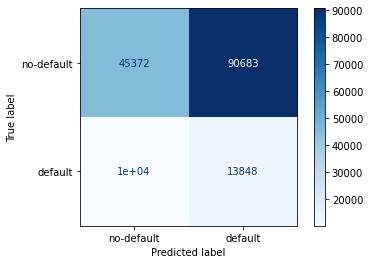

In [8]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(lr_bias, 
                      X_test_bias, 
                      y_test,
                      display_labels=['no-default', 'default'],
                      cmap=plt.cm.Blues)
plt.grid(False)

# Deep Learning

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [10]:
#stop if no improvement in loss after 3 epochs
es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

#class weight
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

/Users/Rolf/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=0       1
1       1
2       1
3       1
4       1
       ..
7995    0
7996    0
7997    0
7998    0
7999    0
Name: default, Length: 471136, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [56]:
def create_model(df):
    ## Initialize model.
    model = Sequential() #if you want a recurrent NN, then specify here Recurrent()

    ## 1st Layer
    model.add(Dense(64, input_dim=df.shape[1]))
    model.add(Activation('relu'))
    model.add(Dropout(0.5)) #25% of neurons are de-activated randomly per batch. helps with generalisation.

    ## 2nd Layer
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.5)) #dropout number is arbitrary. trail and error. 

    ## Adding Softmax Layer
    model.add(Dense(1))
    model.add(Activation('sigmoid')) #softmax used for classification. softmax = [0,1]

    ## Define loss function
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], weighted_metrics=['accuracy'])

    return model

K-fold validation from this website:

https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

In [42]:
#Cross-validation
from sklearn.model_selection import StratifiedKFold

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []

def kfold_validation(X, y):

    X_df = pd.DataFrame(X)
    cvscores = []
    
    for train, test in kfold.split(X_df, y):
        model = create_model(X_df)
        model.fit(X_df.iloc[train], y.iloc[train], epochs=100, batch_size=1000, shuffle=True, verbose=2, 
                  callbacks=[es_callback], class_weight=class_weights)
        scores = model.evaluate(X_df.iloc[test], y.iloc[test], verbose=0)
        
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    
    return model

In [43]:
FNN_bias = kfold_validation(X_tr_bias, y_train)

Epoch 1/100
 - 2s - loss: 827.2225 - accuracy: 0.5009
Epoch 2/100
 - 2s - loss: 4.6104 - accuracy: 0.4996
Epoch 3/100
 - 3s - loss: 2.5754 - accuracy: 0.4994
Epoch 4/100
 - 2s - loss: 1.5495 - accuracy: 0.4986
Epoch 5/100
 - 2s - loss: 1.2464 - accuracy: 0.4996
Epoch 6/100
 - 2s - loss: 0.9879 - accuracy: 0.4997
Epoch 7/100
 - 2s - loss: 0.9401 - accuracy: 0.4988
Epoch 8/100
 - 1s - loss: 0.9241 - accuracy: 0.4999
Epoch 9/100
 - 1s - loss: 0.7959 - accuracy: 0.4984
Epoch 10/100
 - 1s - loss: 0.8259 - accuracy: 0.5005
Epoch 11/100
 - 1s - loss: 0.8205 - accuracy: 0.5006
Epoch 12/100
 - 1s - loss: 0.8201 - accuracy: 0.5002
accuracy: 50.01%
Epoch 1/100
 - 2s - loss: 460.0927 - accuracy: 0.4994
Epoch 2/100
 - 1s - loss: 3.5836 - accuracy: 0.4996
Epoch 3/100
 - 1s - loss: 1.8319 - accuracy: 0.4998
Epoch 4/100
 - 1s - loss: 1.2898 - accuracy: 0.4982
Epoch 5/100
 - 1s - loss: 1.0673 - accuracy: 0.5007
Epoch 6/100
 - 1s - loss: 1.0344 - accuracy: 0.4990
Epoch 7/100
 - 1s - loss: 0.9197 - accur

 - 1s - loss: 3.9309 - accuracy: 0.4997
Epoch 4/100
 - 1s - loss: 2.8101 - accuracy: 0.4997
Epoch 5/100
 - 1s - loss: 1.5710 - accuracy: 0.5001
Epoch 6/100
 - 1s - loss: 1.3122 - accuracy: 0.4994
Epoch 7/100
 - 1s - loss: 1.1399 - accuracy: 0.4999
Epoch 8/100
 - 1s - loss: 1.0237 - accuracy: 0.4996
Epoch 9/100
 - 1s - loss: 0.9756 - accuracy: 0.4997
Epoch 10/100
 - 2s - loss: 0.9821 - accuracy: 0.4992
Epoch 11/100
 - 1s - loss: 0.8547 - accuracy: 0.4996
Epoch 12/100
 - 2s - loss: 0.8412 - accuracy: 0.4990
Epoch 13/100
 - 2s - loss: 0.8509 - accuracy: 0.5010
Epoch 14/100
 - 2s - loss: 0.8123 - accuracy: 0.5008
Epoch 15/100
 - 2s - loss: 0.7538 - accuracy: 0.5000
Epoch 16/100
 - 1s - loss: 0.7547 - accuracy: 0.5007
Epoch 17/100
 - 1s - loss: 0.7351 - accuracy: 0.4999
Epoch 18/100
 - 1s - loss: 0.7310 - accuracy: 0.5005
Epoch 19/100
 - 1s - loss: 0.7313 - accuracy: 0.5016
Epoch 20/100
 - 1s - loss: 0.7078 - accuracy: 0.4999
Epoch 21/100
 - 1s - loss: 0.7160 - accuracy: 0.4994
Epoch 22/100

## Model with bias

In [57]:
#bias
FNN_bias = create_model(X_train_bias)
FNN_bias.fit(X_train_bias, y_train, epochs=100, batch_size=1000, shuffle=True, verbose=2, callbacks=[es_callback],
            class_weight=class_weights)

Epoch 1/100
 - 2s - loss: 0.0564 - accuracy: 0.9821 - accuracy_1: 0.9821
Epoch 2/100
 - 1s - loss: 0.0035 - accuracy: 0.9996 - accuracy_1: 0.9996
Epoch 3/100
 - 1s - loss: 0.0028 - accuracy: 0.9997 - accuracy_1: 0.9997
Epoch 4/100
 - 1s - loss: 0.0022 - accuracy: 0.9998 - accuracy_1: 0.9998
Epoch 5/100
 - 1s - loss: 0.0021 - accuracy: 0.9998 - accuracy_1: 0.9998
Epoch 6/100
 - 2s - loss: 0.0020 - accuracy: 0.9998 - accuracy_1: 0.9998
Epoch 7/100
 - 2s - loss: 0.0019 - accuracy: 0.9998 - accuracy_1: 0.9998
Epoch 8/100
 - 1s - loss: 0.0018 - accuracy: 0.9998 - accuracy_1: 0.9998
Epoch 9/100
 - 1s - loss: 0.0019 - accuracy: 0.9998 - accuracy_1: 0.9998
Epoch 10/100
 - 2s - loss: 0.0017 - accuracy: 0.9998 - accuracy_1: 0.9998
Epoch 11/100
 - 2s - loss: 0.0018 - accuracy: 0.9998 - accuracy_1: 0.9998
Epoch 12/100
 - 2s - loss: 0.0016 - accuracy: 0.9998 - accuracy_1: 0.9998
Epoch 13/100
 - 2s - loss: 0.0017 - accuracy: 0.9998 - accuracy_1: 0.9998
Epoch 14/100
 - 2s - loss: 0.0016 - accuracy: 0

In [44]:
#bias
loss_dl_bias, accuracy_dl_bias = FNN_bias.evaluate(X_test_bias, y_test)
print('Test loss with bias: ' + str(round(loss_dl_bias, 2)))
print('Test accuracy with bias: ' + str(round(accuracy_dl_bias*100, 2)))

160000/160000 [==============================] - 3s 21us/step
Test loss with bias: 0.69
Test accuracy with bias: 14.96


In [54]:
from sklearn.metrics import classification_report

#bias
y_pred_bias = FNN_bias.predict_classes(X_test_bias, verbose=1)

print(classification_report(y_test, y_pred_bias))

160000/160000 [==============================] - 2s 13us/step
              precision    recall  f1-score   support

           0       0.27      0.00      0.00    136055
           1       0.15      1.00      0.26     23945

    accuracy                           0.15    160000
   macro avg       0.21      0.50      0.13    160000
weighted avg       0.25      0.15      0.04    160000



## Model with non-bias dataset

In [13]:
#no bias
FNN_nob = create_model(X_train_nob)
FNN_nob.fit(X_train_nob, y_train, epochs=100, batch_size=1000, shuffle=True, verbose=2, callbacks=[es_callback],
           class_weight=class_weights)

Epoch 1/100
 - 2s - loss: 0.6974 - accuracy: 0.5005
Epoch 2/100
 - 1s - loss: 0.6934 - accuracy: 0.4999
Epoch 3/100
 - 1s - loss: 0.6932 - accuracy: 0.5007
Epoch 4/100
 - 1s - loss: 0.6932 - accuracy: 0.4997
Epoch 5/100
 - 1s - loss: 0.6932 - accuracy: 0.5004
Epoch 6/100
 - 1s - loss: 0.6932 - accuracy: 0.5001
Epoch 7/100
 - 1s - loss: 0.6932 - accuracy: 0.5004
Epoch 8/100
 - 2s - loss: 0.6932 - accuracy: 0.4998
Epoch 9/100
 - 2s - loss: 0.6932 - accuracy: 0.4999
Epoch 10/100
 - 2s - loss: 0.6932 - accuracy: 0.4991


In [17]:
#no bias
loss_dl_nob, accuracy_dl_nob = FNN_nob.evaluate(X_test_nob, y_test)
print('Test loss with no bias: ' + str(round(loss_dl_nob, 2)))
print('Test accuracy with no bias: ' + str(round(accuracy_dl_nob*100, 2)))

160000/160000 [==============================] - 4s 23us/step
Test loss with no bias: 0.69
Test accuracy with no bias: 78.65


In [55]:
#no bias
y_pred_nob = FNN_nob.predict_classes(X_test_nob)

print(classification_report(y_test, y_pred_nob))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92    136055
           1       0.00      0.00      0.00     23945

    accuracy                           0.85    160000
   macro avg       0.43      0.50      0.46    160000
weighted avg       0.72      0.85      0.78    160000



/Users/Rolf/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Fairness of model

In [19]:
def bias_analysis(X_test_df, y_test_df, df_column_names, model, bias, minority):
    """ 
    X_test_df = X_test after StandardScaler transformation
    y_test_df = y_test 
    df_columns_names = X_test dataframe before StandardScaler transformation
    model = deep learning model
    bias = 0 or 1
    minority = 0 or 1
    """
    
    #join minority variable to X and y dataframes to differentiate between minority and non-minority
    X_test_min = np.concatenate((X_test_df, 
                                 test['minority'].values.reshape(-1,1)), 
                                axis=1)
    y_test_min = np.concatenate((y_test_df.values.reshape(-1,1),
                                 test['minority'].values.reshape(-1,1)), 
                                axis=1)
    
    #column headings for dataframe that will be converted from array
    columns = np.insert(df_column_names.columns, X_test_df.shape[1], 'minority')
    
    #convert numpy array to dataframe
    df_X_test = pd.DataFrame(X_test_min, columns=columns)
    df_y_test = pd.DataFrame(y_test_min, columns=['default','minority'])
    
    #subset minority==1, minority group
    X_minority = df_X_test[df_X_test['minority']==minority].values
    y_minority = df_y_test[df_y_test['minority']==minority].values
    
    #predict y
    y_pred_minority = model.predict_classes(X_minority[:,:X_test_df.shape[1]])

    #evaluate accuracy
    loss_dl_min, accuracy_dl_min = model.evaluate(X_minority[:,:X_test_df.shape[1]], y_minority[:,0])
    
    confusion = confusion_matrix(y_minority[:,0], y_pred_minority)
    
    if bias == 1:
        if minority == 1:
        
            print('Test loss bias minority: ' + str(round(loss_dl_min, 2)))
            print('Test accuracy bias minority: ' + str(round(accuracy_dl_min*100, 2)) + '%')

            print()

            return confusion

        else:

            print('Test loss bias non-minority: ' + str(round(loss_dl_min, 2)))
            print('Test accuracy bias non-minority: ' + str(round(accuracy_dl_min*100, 2)) + '%')

            print()

            return confusion
      
    #bias=0
    if bias == 0:
        if minority == 1:

            print('Test loss non-bias minority: ' + str(round(loss_dl_min, 2)))
            print('Test accuracy non-bias minority: ' + str(round(accuracy_dl_min*100, 2)) + '%')

            print()

            return confusion

        else:
            
            print('Test loss non-bias non-minority: ' + str(round(loss_dl_min, 2)))
            print('Test accuracy non-bias non-minority: ' + str(round(accuracy_dl_min*100, 2)) + '%')

            print()

            return confusion

In [20]:
def bias_check(bias, minority):
    """
    bias = 0 or 1
        bias==1 means dataset is biased
    minority = 0 or 1
        minority==1 means minority is analysed

    """
    
    if bias == 1:
        result = bias_analysis(X_test_bias, y_test, X_te_bias, FNN_bias, bias=bias, minority=minority)
        return result
    
    if bias == 0:
        result = bias_analysis(X_test_nob, y_test, X_te_nob, FNN_nob, bias=bias, minority=minority)
        return result

In [106]:
confusion_bias_minority = bias_check(bias=1, minority=1)

80348/80348 [==============================] - 1s 17us/step
Test loss bias minority: 13.99
Test accuracy bias minority: 27.28%



In [22]:
confusion_bias_non_minority = bias_check(bias=1, minority=0)

79652/79652 [==============================] - 2s 23us/step
Test loss bias non-minority: 4.2
Test accuracy bias non-minority: 83.13%



In [23]:
confusion_non_bias_minority = bias_check(bias=0, minority=1)

80348/80348 [==============================] - 2s 20us/step
Test loss non-bias minority: 0.69
Test accuracy non-bias minority: 78.68%



In [24]:
confusion_non_bias_non_minority = bias_check(bias=0, minority=0)

79652/79652 [==============================] - 2s 20us/step
Test loss non-bias non-minority: 0.69
Test accuracy non-bias non-minority: 78.62%



<img src=images/confusionMatrix.jpg>

<img src=images/metrics_1.png>

# Demographic Parity

Really good article explaining fairness measures in ML
https://towardsdatascience.com/how-to-define-fairness-to-detect-and-prevent-discriminatory-outcomes-in-machine-learning-ef23fd408ef2

Positive rate for both minority and non-minority should be the same. This means that the rate of (false positive + true positive) be similar for both groups. For example, the model should predict a 50% default rate in both minority and non-minority. 

Overall, demographic parity does not exist for this dataset since 99% default rate is predicted for the minority group and less than 1% for the non-minority group.

<img src=images/demographic_parity.png>

In [25]:
def demographic_parity(result, bias=0, minority=0):
    """
    bias = 0 or 1
        bias==1 means dataset is biased
    minority = 0 or 1
        minority==1 means minority is analysed

    """
    
    tn, fp, fn, tp = result.ravel()
    #tn, fp, fn, tp = bias_check(bias, minority).ravel()
    
    temp = (fp + tp) / (tn + fp + fn + tp)
    demo_parity = round(temp*100, 2) 
    
    if bias == 1:
        if minority == 0:
            print('Demographic parity for bias non-minority: ' + str(demo_parity) + '%')
            return demo_parity
        
        else: 
            print('Demographic parity for bias minority: ' + str(demo_parity) + '%')
            return demo_parity    
    if bias == 0:
        if minority == 0:
            print('Demographic parity for non-bias non-minority: ' + str(demo_parity) + '%')
            return demo_parity        
        else: 
            print('Demographic parity for non-bias minority: ' + str(demo_parity) + '%')
            return demo_parity            

In [26]:
def if_equal(df):
    for index, row in df.iterrows():
        if abs(row['minority'] - row['non-minority'])> 2:
            df.loc[index, 'equal'] = 'No'
        else:
            df.loc[index, 'equal'] = 'Yes'
        

In [27]:
demo_parity = pd.DataFrame(index=['bias', 'non-bias'])

In [28]:
#bias
demo_parity.loc['bias', 'minority'] = demographic_parity(confusion_bias_minority, bias=1, minority=1)
demo_parity.loc['bias', 'non-minority'] = demographic_parity(confusion_bias_non_minority, bias=1, minority=0)

Demographic parity for bias minority: 84.09%
Demographic parity for bias non-minority: 3.86%


In [29]:
#non-bias
demo_parity.loc['non-bias', 'minority'] = demographic_parity(confusion_non_bias_minority, bias=0, minority=1)
demo_parity.loc['non-bias', 'non-minority'] = demographic_parity(confusion_non_bias_non_minority, bias=0, minority=0)

Demographic parity for non-bias minority: 9.01%
Demographic parity for non-bias non-minority: 9.11%


In [30]:
if_equal(demo_parity)
demo_parity

,minority,non-minority,equal
bias,84.09,3.86,No
non-bias,9.01,9.11,Yes


# Equal Opportunity

The false negative and true positive rate should be the same for both groups. 

Overall, equal opportunity exists since both groups correctly predict default rate to 100%. 

<img src=images/equal_opportunity.png>

In [31]:
def equal_opportunity(result, bias=0, minority=0):
    """
    bias = 0 or 1
        bias==1 means dataset is biased
    minority = 0 or 1
        minority==1 means minority is analysed

    """
    
    tn, fp, fn, tp = result.ravel()
    #tn, fp, fn, tp = bias_check(bias, minority).ravel()
    
    temp = tp / (fn + tp)
    equal_opportunity = round(temp*100, 2) 
    
    if bias == 1:
        if minority == 0:
            print('Equal opportunity for bias non-minority: ' + str(equal_opportunity) + '%')
            return equal_opportunity
        
        else: 
            print('Equal opportunity for bias minority: ' + str(equal_opportunity) + '%')
            return equal_opportunity
    
    if bias == 0:
        if minority == 0:
            print('Equal opportunity for non-bias non-minority: ' + str(equal_opportunity) + '%')
            return equal_opportunity
        
        else: 
            print('Equal opportunity for non-bias minority: ' + str(equal_opportunity) + '%')
            return equal_opportunity

In [32]:
equal_opp = pd.DataFrame(index=['bias', 'non-bias'])

In [33]:
#bias
equal_opp.loc['bias', 'minority'] = equal_opportunity(confusion_bias_minority, bias=1, minority=1)
equal_opp.loc['bias', 'non-minority'] = equal_opportunity(confusion_bias_non_minority, bias=1, minority=0)

Equal opportunity for bias minority: 87.84%
Equal opportunity for bias non-minority: 6.37%


In [34]:
#non-bias
equal_opp.loc['non-bias', 'minority'] = equal_opportunity(confusion_non_bias_minority, bias=0, minority=1)
equal_opp.loc['non-bias', 'non-minority'] = equal_opportunity(confusion_non_bias_non_minority, bias=0, minority=0)

Equal opportunity for non-bias minority: 9.05%
Equal opportunity for non-bias non-minority: 8.84%


In [35]:
if_equal(equal_opp)
equal_opp

,minority,non-minority,equal
bias,87.84,6.37,No
non-bias,9.05,8.84,Yes


# Equalised Odds

<img src=images/equalised_odds.png>

In [42]:
def equalised_odds(result, bias=0, minority=0):
    """
    bias = 0 or 1
        bias==1 means dataset is biased
    minority = 0 or 1
        minority==1 means minority is analysed

    """
    
    tn, fp, fn, tp = result.ravel()
    #tn, fp, fn, tp = bias_check(bias, minority).ravel()
    
    temp = tp / (fn + tp)
    true_positive_rate = round(temp*100, 2)
    
    temp = tn / (fp + tn)
    true_negative_rate = round(temp*100, 2)
    
    if bias == 1:
        if minority == 0:
            print()
            print('True positive rate for bias non-minority: ' + str(true_positive_rate) + '%')
            print('True negative rate for bias non-minority: ' + str(true_negative_rate) + '%')
            return true_positive_rate, true_negative_rate
        
        else: 
            print()
            print('True positive rate for bias minority: ' + str(true_positive_rate) + '%')
            print('True negative rate for bias minority: ' + str(true_negative_rate) + '%')
            return true_positive_rate, true_negative_rate
    
    if bias == 0:
        if minority == 0:
            print()
            print('True positive rate for non-bias non-minority: ' + str(true_positive_rate) + '%')
            print('True negative rate for non-bias non-minority: ' + str(true_negative_rate) + '%')
            return true_positive_rate, true_negative_rate
        
        else: 
            print()
            print('True positive rate for non-bias minority: ' + str(true_positive_rate) + '%')
            print('True negative rate for non-minority: ' + str(true_negative_rate) + '%')
            return true_positive_rate, true_negative_rate

In [43]:
equal_odds_tpr = pd.DataFrame(index=['bias', 'non-bias'])
equal_odds_tnr = pd.DataFrame(index=['bias', 'non-bias'])

In [44]:
#bias
equal_odds_tpr.loc['bias', 'minority'], equal_odds_tnr.loc['bias', 'minority'] = equalised_odds(confusion_bias_minority, bias=1, minority=1)
equal_odds_tpr.loc['bias', 'non-minority'], equal_odds_tnr.loc['bias', 'non-minority'] = equalised_odds(confusion_bias_non_minority, bias=1, minority=0)

#non-bias
equal_odds_tpr.loc['non-bias', 'minority'], equal_odds_tnr.loc['non-bias', 'minority'] = equalised_odds(confusion_non_bias_minority, bias=0, minority=1)
equal_odds_tpr.loc['non-bias', 'non-minority'], equal_odds_tnr.loc['non-bias', 'non-minority'] = equalised_odds(confusion_non_bias_non_minority, bias=0, minority=0)


True positive rate for bias minority: 87.84%
True negative rate for bias minority: 16.57%

True positive rate for bias non-minority: 6.37%
True negative rate for bias non-minority: 96.58%

True positive rate for non-bias minority: 9.05%
True negative rate for non-minority: 91.0%

True positive rate for non-bias non-minority: 8.84%
True negative rate for non-bias non-minority: 90.84%


In [40]:
#true positive rate
if_equal(equal_odds_tpr)
equal_odds_tpr

,minority,non-minority,equal
bias,87.84,6.37,No
non-bias,9.05,8.84,Yes


In [41]:
#true negative rate
if_equal(equal_odds_tnr)
equal_odds_tnr

,minority,non-minority,equal
bias,16.57,96.58,No
non-bias,91.00,90.84,Yes


# Disparate Impact Remover

Notebook on how to remove bias in a variable: https://nbviewer.jupyter.org/github/srnghn/bias-mitigation-examples/blob/master/Bias%20Mitigation%20with%20Disparate%20Impact%20Remover.ipynb

## Disparate impact is the same as demographic parity

In [46]:
#disparate impact calculator
def calc_prop(data, group_col, group, output_col, output_val):
    new = data[data[group_col] == group]
    return len(new[new[output_col] == output_val])/len(new)

In [108]:
#disparate impact of minority
pr_minority = calc_prop(train, "minority", 1, "default", 1)
print(pr_minority)

0.9989379959558886


In [109]:
#disparate impact of non-minority
pr_non_minority = calc_prop(train, "minority", 0, "default", 1)
print(pr_non_minority)

0.0014465579556445455


In [52]:
pr_minority / pr_non_minority

0.0010635425200048792

The industry standard is a four-fifths rule: if the unprivileged group receives a positive outcome less than 80% of their proportion of the privilege group, this is a disparate impact violation. However, you may decide to increase this for your business.

## check on test dataset

In [91]:
pred_bias_np = np.concatenate((test[['minority']],
                                y_pred_bias), 
                                axis=1)
pred_bias_df = pd.DataFrame(pred_bias_np, columns=['minority', 'preds'])
pred_bias_df.head()

,minority,preds
0,1,1
1,0,0
2,0,0
3,1,1
4,1,1


In [112]:
#disparate impact of minority
dl_pr_minority = calc_prop(pred_bias_df, "minority", 1, "preds", 1)
print(dl_pr_minority)

0.8409170110021407


In [113]:
#disparate impact of non-minority
dl_pr_non_minority = calc_prop(pred_bias_df, "minority", 0, "preds", 1)
print(dl_pr_non_minority)

0.03863054286144729


In [115]:
dl_pr_non_minority / dl_pr_minority

0.04593859127122468

In [117]:
%pip install aif360

Note: you may need to restart the kernel to use updated packages.


In [119]:
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from numba.core.decorators import jit

In [122]:
train_BLD = BinaryLabelDataset(favorable_label='1',
                                unfavorable_label='0',
                                df=train,
                                label_names=['default'],
                                protected_attribute_names=['minority'],
                                unprivileged_protected_attributes=['1'])
test_BLD = BinaryLabelDataset(favorable_label='1',
                                unfavorable_label='0',
                                df=test,
                                label_names=['default'],
                                protected_attribute_names=['minority'],
                                unprivileged_protected_attributes=['1'])

In [125]:
di = DisparateImpactRemover(repair_level=1.0)
rp_train = di.fit_transform(train_BLD)
rp_test = di.fit_transform(test_BLD)

In [146]:
#minority and sex need to be dropped
train_BLD.feature_names

['minority',
 'sex',
 'ZIP',
 'rent',
 'education',
 'age',
 'income',
 'loan_size',
 'payment_timing',
 'year',
 'job_stability',
 'occupation']

In [166]:
rp_train.features[0, 2:]

array([1.00000000e+00, 1.00000000e+00, 5.71446379e+01, 3.60509266e+01,
       2.04987077e+05, 7.57872674e+03, 3.29863349e+00, 0.00000000e+00,
       3.01555352e+00, 0.00000000e+00])

In [184]:
rp_train.labels

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [185]:
#no bias
FNN_rp = create_model(rp_train.features[:, 2:])
FNN_rp.fit(rp_train.features[:, 2:], rp_train.labels, epochs=100, batch_size=1000, shuffle=True, verbose=2, callbacks=[es_callback])

Epoch 1/100
 - 2s - loss: 902.3524 - accuracy: 0.4996
Epoch 2/100
 - 1s - loss: 6.2523 - accuracy: 0.4991
Epoch 3/100
 - 1s - loss: 1.5655 - accuracy: 0.5002
Epoch 4/100
 - 1s - loss: 1.1936 - accuracy: 0.4992
Epoch 5/100
 - 1s - loss: 1.0759 - accuracy: 0.4982
Epoch 6/100
 - 1s - loss: 0.8810 - accuracy: 0.4990
Epoch 7/100
 - 1s - loss: 0.8730 - accuracy: 0.4999
Epoch 8/100
 - 1s - loss: 0.8091 - accuracy: 0.4992
Epoch 9/100
 - 2s - loss: 0.8192 - accuracy: 0.5007
Epoch 10/100
 - 1s - loss: 0.7707 - accuracy: 0.4998
Epoch 11/100
 - 1s - loss: 0.7420 - accuracy: 0.5008
Epoch 12/100
 - 1s - loss: 0.7582 - accuracy: 0.4992
Epoch 13/100
 - 1s - loss: 0.7508 - accuracy: 0.4994
Epoch 14/100
 - 1s - loss: 0.7255 - accuracy: 0.5000
Epoch 15/100
 - 2s - loss: 0.7132 - accuracy: 0.4999
Epoch 16/100
 - 2s - loss: 0.7204 - accuracy: 0.4988
Epoch 17/100
 - 2s - loss: 0.7078 - accuracy: 0.4995
Epoch 18/100
 - 2s - loss: 0.6987 - accuracy: 0.4993
Epoch 19/100
 - 1s - loss: 0.6970 - accuracy: 0.4998


In [187]:
di_preds = FNN_rp.predict(rp_test.features[:, 2:])

In [188]:
di_pred_np = np.concatenate((test[['minority']],
                                di_preds), 
                                axis=1)
di_pred_df = pd.DataFrame(di_pred_np, columns=['minority', 'preds'])
di_pred_df.head()

,minority,preds
0,1.0,0.501868
1,0.0,0.501868
2,0.0,0.501868
3,1.0,0.501868
4,1.0,0.501868


In [183]:
di_preds

array([[0.500161],
       [0.500161],
       [0.500161],
       ...,
       [0.500161],
       [0.500161],
       [0.500161]], dtype=float32)

In [189]:
di_lr_pr_unpriv = calc_prop(di_pred_df,"minority",0,"preds",1)
print(di_lr_pr_unpriv)

0.0


In [177]:
di_lr_pr_priv = calc_prop(di_pred_df,"minority",1,"preds",1)
print(di_lr_pr_priv)

0.0
